In [1]:
import numpy as np
import pandas as pd
from allensdk.core.cell_types_cache import CellTypesCache
from allensdk.ephys.ephys_extractor import EphysSweepFeatureExtractor
from pathlib import Path

# --- Setup ---
cache_dir = "./cell_types"
ctc = CellTypesCache(manifest_file=Path(cache_dir) / "manifest.json")
specimen_id = 616647103
data_set = ctc.get_ephys_data(specimen_id)
sweeps = ctc.get_ephys_sweeps(specimen_id)

# --- Filter long square sweeps ---
long_square_sweeps = [s for s in sweeps if s['stimulus_name'] == 'Long Square']
training_data = []

# --- Extract features and spike counts ---
for s in long_square_sweeps:
    try:
        sw_data = data_set.get_sweep(s["sweep_number"])
        v = sw_data["response"] * 1e3
        i = sw_data["stimulus"] * 1e12
        t = np.arange(len(v)) / sw_data["sampling_rate"]

        ext = EphysSweepFeatureExtractor(t=t, v=v, i=i, start=1.02, end=2.02)
        ext.process_spikes()
        spike_count = len(ext.spike_feature("threshold_t"))

        stim_window = (t >= 1.02) & (t <= 2.02)
        stim_segment = i[stim_window]

        features = {
            "stim_mean": np.mean(stim_segment),
            "stim_max": np.max(stim_segment),
            "stim_min": np.min(stim_segment),
            "spike_count": spike_count
        }
        training_data.append(features)
    except Exception:
        continue

# --- Create DataFrame ---
df = pd.DataFrame(training_data)
print("Sample training data:")
print(df.head())


Sample training data:
    stim_mean  stim_max  stim_min  spike_count
0 -109.889999       0.0    -110.0            0
1  -89.910004       0.0     -90.0            0
2  -69.930000       0.0     -70.0            0
3  -49.950001       0.0     -50.0            0
4    9.990000      10.0       0.0            0


Epoch 1/100


/Users/jainigandhi/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 567ms/step - loss: 13.1925 - mae: 2.2378 - val_loss: 10.4862 - val_mae: 2.3092
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 13.0998 - mae: 2.2213 - val_loss: 10.4087 - val_mae: 2.2962
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 13.0083 - mae: 2.2051 - val_loss: 10.3316 - val_mae: 2.2832
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 12.9207 - mae: 2.1892 - val_loss: 10.2550 - val_mae: 2.2702
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 12.8338 - mae: 2.1734 - val_loss: 10.1788 - val_mae: 2.2573
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 12.7482 - mae: 2.1585 - val_loss: 10.1030 - val_mae: 2.2443
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 12.6632 - mae: 2.1436 - val_loss: 10.0277 - val_mae: 2.2315
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 12.5779 - mae: 2.1287 - val_loss: 9.9527 - val_mae: 2.2187
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 12.4927 - 

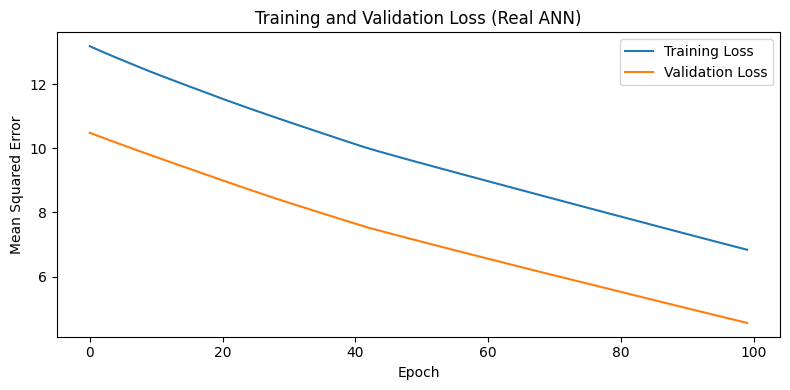

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping



# --- Prepare Data ---
X = df[["stim_mean", "stim_max", "stim_min"]].values
y = df["spike_count"].values

# Normalize inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, random_state=42)

# --- Build ANN Model ---
model = Sequential()
model.add(Dense(16, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))  # Output: spike count (regression)

model.compile(optimizer='adam', loss='mse', metrics=['mae'])

early_stop = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# --- Train the model ---
history = model.fit(X_train, y_train,validation_data=(X_test, y_test),epochs=100,verbose=1,callbacks=[early_stop])

# --- Plot Training Loss (Replace Plot 4 with This) ---
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.title("Training and Validation Loss (Real ANN)")
plt.legend()
plt.tight_layout()
plt.show()




In [6]:
print(df.describe())
print(df["spike_count"].value_counts())

        stim_mean    stim_max    stim_min  spike_count
count   26.000000   26.000000   26.000000    26.000000
mean   113.732307  126.153847  -12.307693     2.000000
std    100.619766   77.256805   30.764605     2.771281
min   -109.889999    0.000000 -110.000000     0.000000
25%     74.925001   75.000000    0.000000     0.000000
50%    129.869995  130.000000    0.000000     1.000000
75%    169.830002  170.000000    0.000000     2.000000
max    249.749985  249.999985    0.000000    10.000000
0     10
1      7
2      3
6      2
4      1
8      1
10     1
5      1
Name: spike_count, dtype: int64


In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

print("Linear Regression MSE:", mean_squared_error(y_test, y_pred_lr))

Linear Regression MSE: 1.1097632569243427
